<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#set-up-input-data" data-toc-modified-id="set-up-input-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>set up input data</a></span></li><li><span><a href="#model-training" data-toc-modified-id="model-training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>model training</a></span></li><li><span><a href="#generate-shap-values-and-base-line-value-for-n-random-observations" data-toc-modified-id="generate-shap-values-and-base-line-value-for-n-random-observations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>generate shap values and base line value for n random observations</a></span></li><li><span><a href="#generate-decision-plot-and-feature-summary-plot" data-toc-modified-id="generate-decision-plot-and-feature-summary-plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>generate decision plot and feature summary plot</a></span></li><li><span><a href="#highlight-mis-classfied-observations" data-toc-modified-id="highlight-mis-classfied-observations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>highlight mis-classfied observations</a></span></li><li><span><a href="#take-a-single-observation-in-the-test-set" data-toc-modified-id="take-a-single-observation-in-the-test-set-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>take a single observation in the test set</a></span></li><li><span><a href="#highlight-the-individual-decision-path" data-toc-modified-id="highlight-the-individual-decision-path-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>highlight the individual decision path</a></span></li></ul></div>

SHAP decision plots show how complex models arrive at their predictions (i.e., how models make decisions). This notebook illustrates decision plot features and use cases with simple examples.

In [1]:
import pandas as pd 
import numpy as np
import lime 
import shap
import os
import xgboost
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import random
import matplotlib.pyplot as pl
np.set_printoptions(suppress=True)

# set up input data

In [2]:
os.getcwd()
pd.set_option('display.max_columns',200)
df_HRF = pd.read_csv('HARBR_XAI_V2.csv')


In [3]:
col_drop = ['ledger_account_number','sar_flag','gender_F','gender_M','customer_type_business','customer_type_individual','annual_income','year_month']

In [4]:
df_copy = df_HRF.drop(col_drop,axis=1).copy()

In [15]:
def generate_display_features(df):
    col_count = ['total_transaction_count']
    col_fluctuation = [x for x in df.columns if 'fluctuation' in x]
    col_ratio = [x for x in df.columns if 'ratio' in x]
    
    for i in col_count:
        df[i] = np.where(df[i]>(df[i].mean()+2*np.std(df[i])),'much higher than average',
                         np.where(df[i]<=(df[i].mean()-2*np.std(df[i])),'significantly lower than average',
                                  np.where(df[i]>(df[i].mean()+np.std(df[i])),'slightly higher than average',
                                           np.where(df[i]<=(df[i].mean()-np.std(df[i])),'slightly lower than average','within normal range'))))
        print(i)
    for i in col_fluctuation:
        df[i] = np.where(df[i]>5,'significantly higher than historical average',
                         np.where((df[i] <= 5 ) & (df[i] >2),'slightly higher than historical average',
                                           'close to historical normal'))
        print(i)
    for i in col_ratio:
        df[i] = np.where(df[i]>5,'ratio significantly higher higher than normal expected range',
                         np.where((df[i]>=1) & (df[i]<=5),'ratio is higher than expected range',
                                           'ratio is within normal range'))
        print(i)        
    return df

In [16]:
df_text = generate_display_features(df_copy)

total_transaction_count
fluctuation_in_credit_behaviour
fluctuation_in_credit_card_spending
fluctuation_in_credit_counterparty_count
fluctuation_in_credit_currency_count
fluctuation_in_credit_velocity
fluctuation_in_debit_behaviour
fluctuation_in_debit_counterparty_count
fluctuation_in_debit_velocity
in_and_out_transaction_ratio
distinct_in_and_out_transfer_ratio
domestic_debit_credit_ratio
wire_debit_credit_ratio
credit_max_to_average_ratio
credit_wire_domestic_ratio
wire_transfer_to_salary_ratio
domestic_transfer_to_salary_ratio
net_payroll_ratio


In [19]:
df_text.fluctuation_in_debit_behaviour.value_counts()

close to historical normal                      2872631
slightly higher than historical average           60517
significantly higher than historical average      45448
Name: fluctuation_in_debit_behaviour, dtype: int64

In [20]:

Y=df_HRF['sar_flag']
X = df_HRF.drop(col_drop,axis=1)

# model training 

In [21]:
rus = RandomUnderSampler(random_state=0)
X_display,Y_display = rus.fit_resample(df_text,Y)

In [22]:
X_resampled, y_resampled = rus.fit_resample(X, Y)

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2,random_state=7)

In [681]:
model = xgboost.XGBClassifier()


In [689]:
model.fit(X_train, Y_train)

[11:00:55] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [690]:
y_pred = model.predict(X_test)

In [693]:
matrix = confusion_matrix(Y_test, y_pred)


In [695]:
score = model.predict_proba(X_test)


In [696]:
sklearn.metrics.roc_auc_score(Y_test.values, score[:,1])


0.9646566291676055

In [718]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82      1930
         1.0       0.83      0.84      0.84      2077

    accuracy                           0.83      4007
   macro avg       0.83      0.83      0.83      4007
weighted avg       0.83      0.83      0.83      4007



In [24]:
model = RandomForestClassifier()

In [25]:
model.fit(X_train, Y_train)  

RandomForestClassifier()

In [26]:
y_pred = model.predict(X_test)

In [27]:
score = model.predict_proba(X_test)

In [28]:
sklearn.metrics.roc_auc_score(Y_test.values, score[:,1])

0.9048854839956993

In [29]:
matrix = confusion_matrix(Y_test, y_pred)

In [30]:
matrix

array([[1547,  383],
       [ 334, 1743]])

In [947]:
from sklearn import tree


In [963]:
tree_model = DecisionTreeClassifier(max_depth= 5)

In [964]:
tree_model.fit(X_train, Y_train)  


DecisionTreeClassifier(max_depth=5)

In [ ]:
tree.plot_tree(tree_model)


In [953]:
from graphviz import Source

In [ ]:
Source( tree.export_graphviz(tree_model, out_file=None, feature_names=X_train.columns))


In [961]:
tree_model.classes_

array([0., 1.])

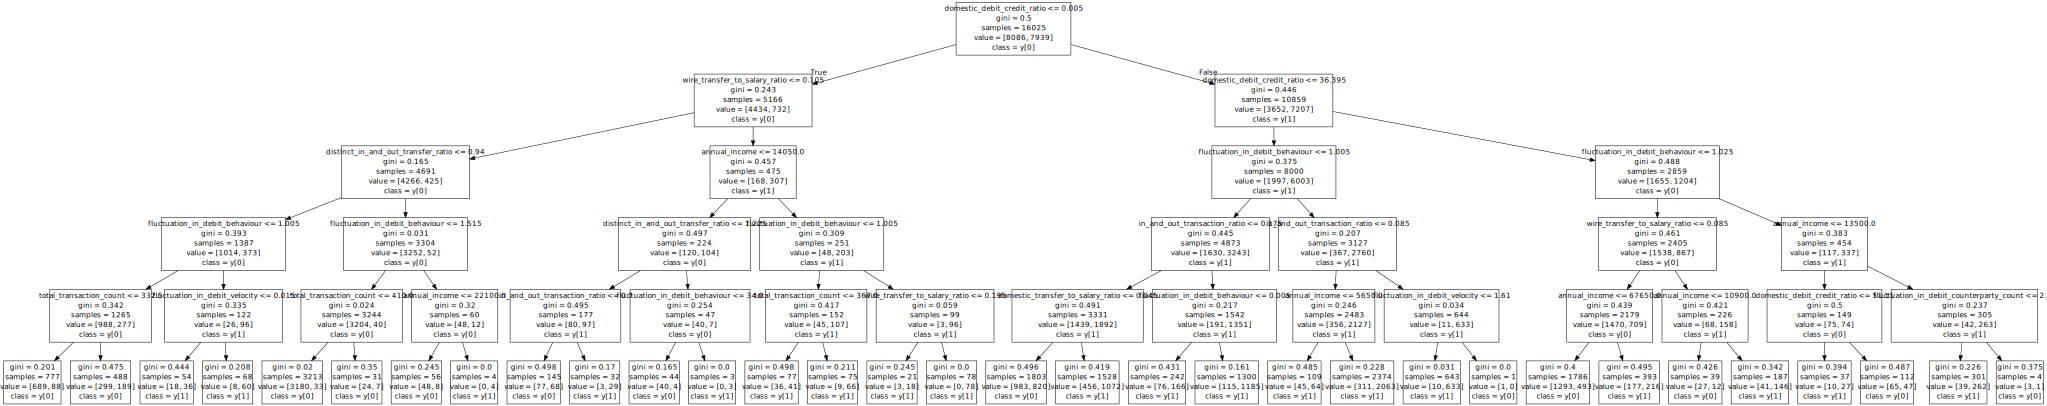

In [965]:
from IPython.display import SVG
graph = Source( tree.export_graphviz(tree_model, out_file=None, feature_names=X_train.columns,class_names=True))
SVG(graph.pipe(format='svg'))

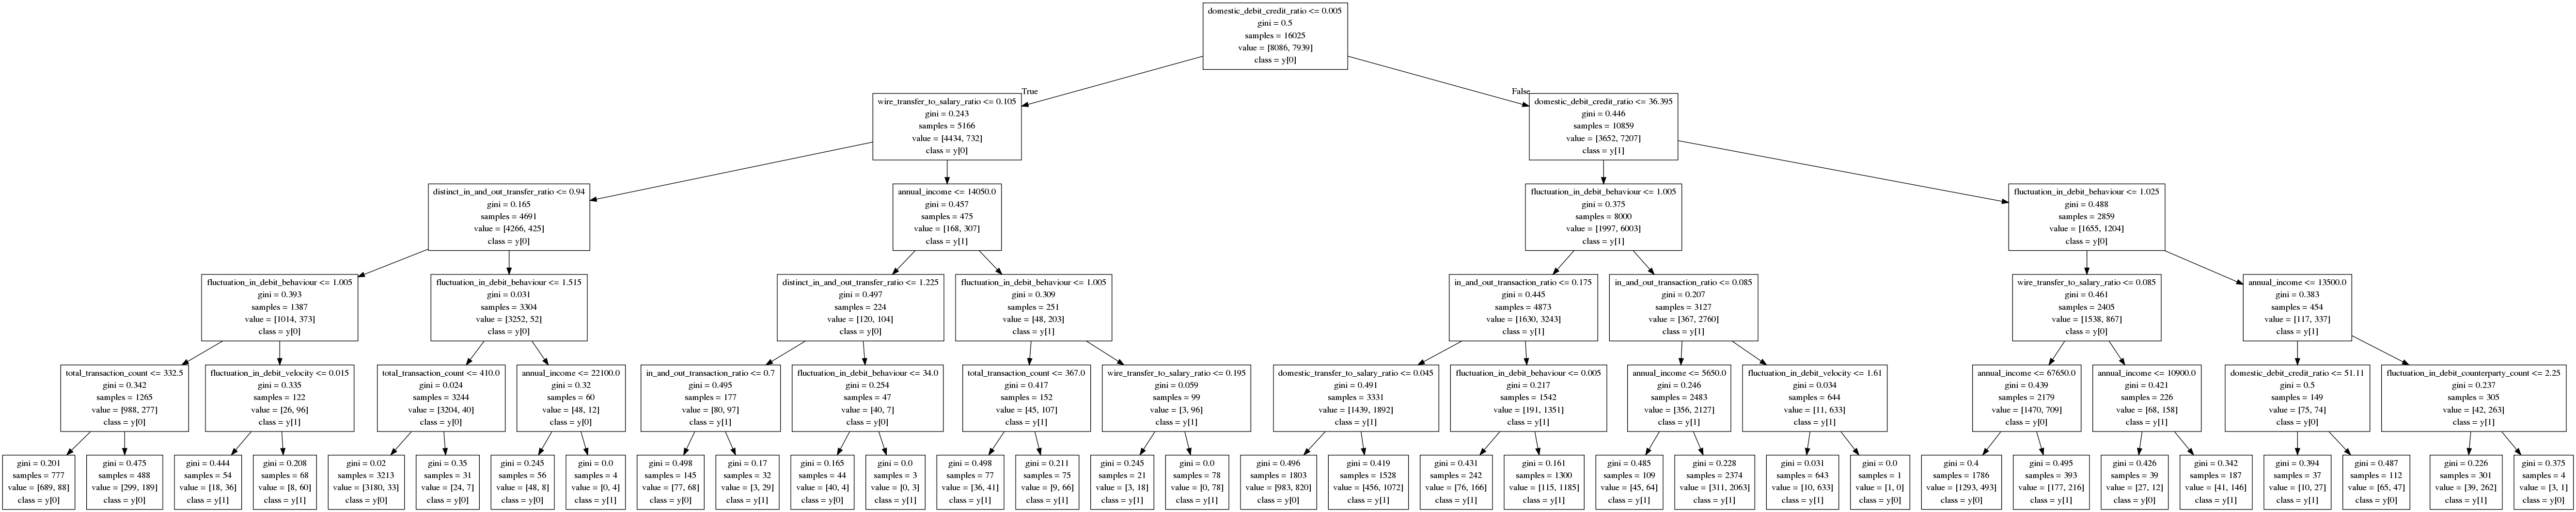

In [972]:
graph = Source( tree.export_graphviz(tree_model, out_file=None, feature_names=X_train.columns,class_names=True))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

In [967]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [968]:
tree_to_code(tree_model,X_train.columns)

def tree(gender_F, total_transaction_count, in_and_out_transaction_ratio, distinct_in_and_out_transfer_ratio, domestic_debit_credit_ratio, wire_debit_credit_ratio, credit_max_to_average_ratio, credit_wire_domestic_ratio, wire_transfer_to_salary_ratio, domestic_transfer_to_salary_ratio, net_payroll_ratio, annual_income, customer_type_individual, fluctuation_in_credit_behaviour, fluctuation_in_credit_card_spending, fluctuation_in_credit_counterparty_count, fluctuation_in_credit_currency_count, fluctuation_in_credit_velocity, fluctuation_in_debit_behaviour, fluctuation_in_debit_counterparty_count, fluctuation_in_debit_velocity):
  if domestic_debit_credit_ratio <= 0.004999999888241291:
    if wire_transfer_to_salary_ratio <= 0.10500000044703484:
      if distinct_in_and_out_transfer_ratio <= 0.9399999976158142:
        if fluctuation_in_debit_behaviour <= 1.0049999952316284:
          if total_transaction_count <= 332.5:
            return [[689.  88.]]
          else:  # if total_transac

In [969]:
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print ("if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print ("} else {")
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print ("}")
                else:
                        print ("return " + str(value[node]))

        recurse(left, right, threshold, features, 0)

In [970]:
get_code(tree_model,X_train.columns)

if ( domestic_debit_credit_ratio <= 0.004999999888241291 ) {
if ( wire_transfer_to_salary_ratio <= 0.10500000044703484 ) {
if ( distinct_in_and_out_transfer_ratio <= 0.9399999976158142 ) {
if ( fluctuation_in_debit_behaviour <= 1.0049999952316284 ) {
if ( total_transaction_count <= 332.5 ) {
return [[689.  88.]]
} else {
return [[299. 189.]]
}
} else {
if ( fluctuation_in_debit_velocity <= 0.014999999664723873 ) {
return [[18. 36.]]
} else {
return [[ 8. 60.]]
}
}
} else {
if ( fluctuation_in_debit_behaviour <= 1.5149999856948853 ) {
if ( total_transaction_count <= 410.0 ) {
return [[3180.   33.]]
} else {
return [[24.  7.]]
}
} else {
if ( annual_income <= 22100.0 ) {
return [[48.  8.]]
} else {
return [[0. 4.]]
}
}
}
} else {
if ( annual_income <= 14050.0 ) {
if ( distinct_in_and_out_transfer_ratio <= 1.225000023841858 ) {
if ( in_and_out_transaction_ratio <= 0.7000000178813934 ) {
return [[77. 68.]]
} else {
return [[ 3. 29.]]
}
} else {
if ( fluctuation_in_debit_behaviour <= 34.0 )

In [981]:
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns,class_names=[0,1], discretize_continuous=True)

In [995]:
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test.iloc[i], tree_model.predict_proba, num_features=10)

In [996]:
exp.show_in_notebook(show_table=True, show_all=True)


In [579]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)  
y_pred = model.predict(X_test)
score = model.predict_proba(X_test)
sklearn.metrics.roc_auc_score(Y_test.values, score[:,1])
# print(classification_report(Y_test, y_pred))
matrix = confusion_matrix(Y_test, y_pred)
# importances = model.feature_importances_
# indices = np.argsort(importances)
label = pd.DataFrame(Y_test)
test_data = X_test.join(label)
# features = X_train.columns
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance`')
# plt.show()

# generate shap values and base line value for n random observations

In [33]:
def generate_shap_values(model,data,number_of_sample):

    explainer = shap.TreeExplainer(model)
    expected_value = explainer.expected_value[0]
    if isinstance(expected_value, list):
        expected_value = expected_value[1]
    print(f"Explainer expected value: {round(expected_value,2)}")


    features = data.sample(n=number_of_sample)


    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        shap_values = explainer.shap_values(features)[1]
        shap_interaction_values = explainer.shap_interaction_values(features)
    if isinstance(shap_interaction_values, list):
        shap_interaction_values = shap_interaction_values[1]
    return shap_values, expected_value,shap_interaction_values,features,explainer

select 5 observations and generate shap values

In [48]:
shap_values,expected_value,shap_interaction_values,sample,explainer = generate_shap_values(model,X_test,20)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Explainer expected value: 0.5


# generate decision plot and feature summary plot

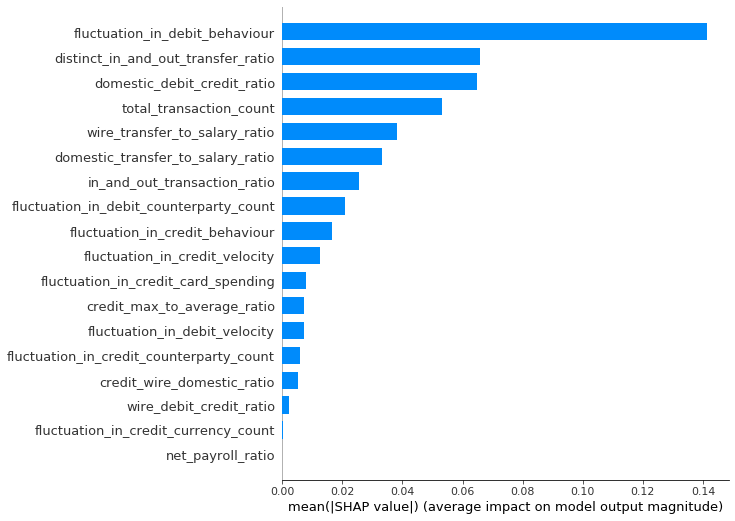

In [34]:
shap.summary_plot(shap_values,sample,plot_type='bar')

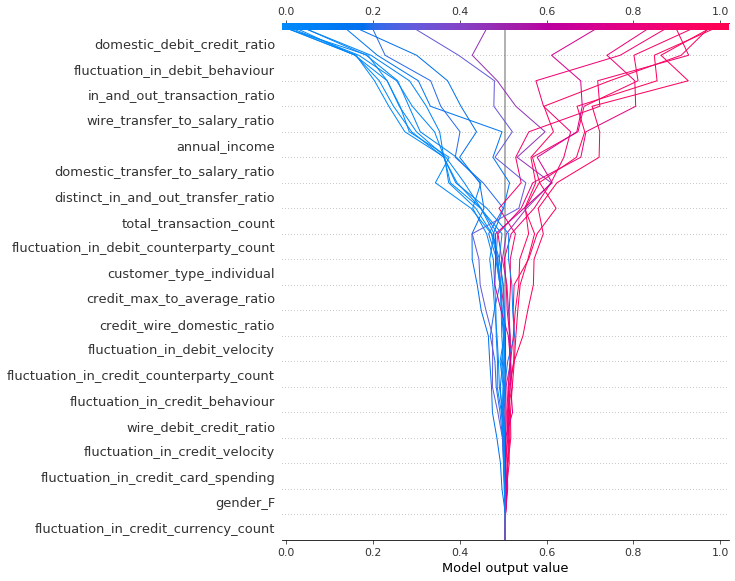

In [824]:
shap.decision_plot(expected_value, shap_values,sample)


# highlight mis-classfied observations

In [541]:
def mis_classified(sample,model,Y_test):
    sample_index = sample.index
    sample_label = Y_test.loc[sample.index].values
    y_pred_sample = model.predict(sample)
    y_pred_score = model.predict_proba(sample)[:,1]    
    misclassified = y_pred_sample != sample_label
    return y_pred_sample,y_pred_score,misclassified

In [542]:
y_sample_pred_label, y_sample_pred_score,misclassified=mis_classified(sample,model,Y_test)

In [543]:
print('sample predicted label:{}'.format(y_sample_pred_label.astype('int')))
print('sample predicted score:{}'.format(y_sample_pred_score))
print('misclassified records:{}'.format(misclassified))


sample predicted label:[0 0 0 0 0]
sample predicted score:[0.42265783 0.25956129 0.36277164 0.48851656 0.48804598]
misclassified records:[ True False False False  True]


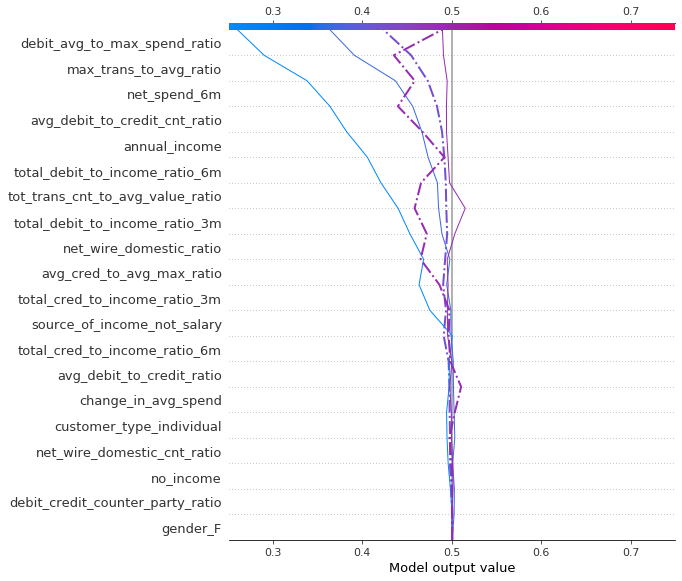

In [544]:
shap.decision_plot(expected_value, shap_values, sample, highlight=misclassified)

In [545]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")


# take a single observation in the test set 

In [35]:
def single_observation_summary(sample,model,Y_test,explainer):
    rand = random.randrange(len(sample)) 
    single_record = sample.iloc[[rand]]
    label = Y_test.loc[single_record.index]
    score = model.predict_proba(single_record)[:,1]
    shap_values = explainer.shap_values(single_record)
    return single_record,label,score,shap_values

In [42]:
df_sample,sample_label,sample_score,shap_values = single_observation_summary(X_test,model,Y_test,explainer)

In [43]:
df_sample

,total_transaction_count,in_and_out_transaction_ratio,distinct_in_and_out_transfer_ratio,domestic_debit_credit_ratio,wire_debit_credit_ratio,credit_max_to_average_ratio,credit_wire_domestic_ratio,wire_transfer_to_salary_ratio,domestic_transfer_to_salary_ratio,net_payroll_ratio,fluctuation_in_credit_behaviour,fluctuation_in_credit_card_spending,fluctuation_in_credit_counterparty_count,fluctuation_in_credit_currency_count,fluctuation_in_credit_velocity,fluctuation_in_debit_behaviour,fluctuation_in_debit_counterparty_count,fluctuation_in_debit_velocity
12421,447.0,0.01,0.33,55.77,1.22,0.19,0.19,0.06,0.11,0.0,0.83,0.0,0.21,0.0,0.14,0.14,0.41,0.02


In [44]:
sample_label, sample_score

(12421    1.0
 Name: sar_flag, dtype: float64, array([0.57]))

# highlight the individual decision path

In [729]:
shap.initjs()

In [938]:
shap.force_plot(expected_value, shap_values, sample)

In [45]:
test = df_text.loc[df_sample.index]

In [46]:
test

,total_transaction_count,in_and_out_transaction_ratio,distinct_in_and_out_transfer_ratio,domestic_debit_credit_ratio,wire_debit_credit_ratio,credit_max_to_average_ratio,credit_wire_domestic_ratio,wire_transfer_to_salary_ratio,domestic_transfer_to_salary_ratio,net_payroll_ratio,fluctuation_in_credit_behaviour,fluctuation_in_credit_card_spending,fluctuation_in_credit_counterparty_count,fluctuation_in_credit_currency_count,fluctuation_in_credit_velocity,fluctuation_in_debit_behaviour,fluctuation_in_debit_counterparty_count,fluctuation_in_debit_velocity
12421,slightly higher than average,ratio is within normal range,ratio is within normal range,ratio significantly higher higher than normal ...,ratio is within normal range,ratio is higher than expected range,ratio is higher than expected range,ratio is within normal range,ratio is within normal range,ratio is within normal range,close to historical normal,close to historical normal,close to historical normal,close to historical normal,close to historical normal,close to historical normal,close to historical normal,close to historical normal


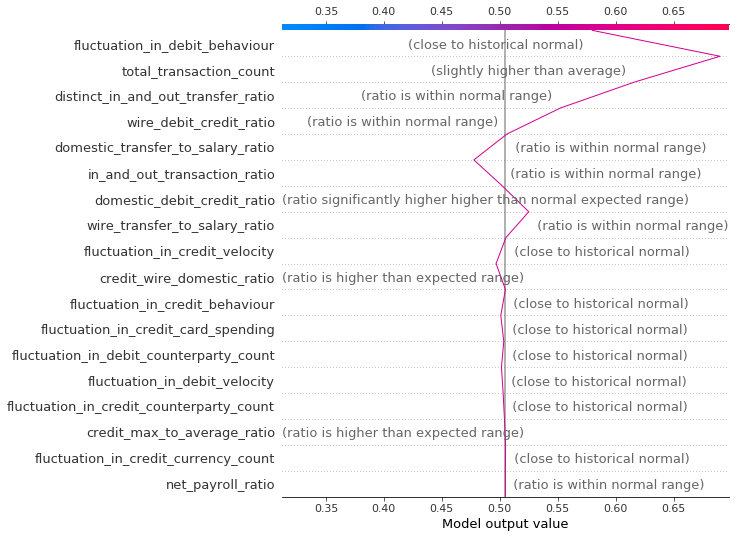

In [47]:
shap.decision_plot(expected_value, shap_values[1], test)


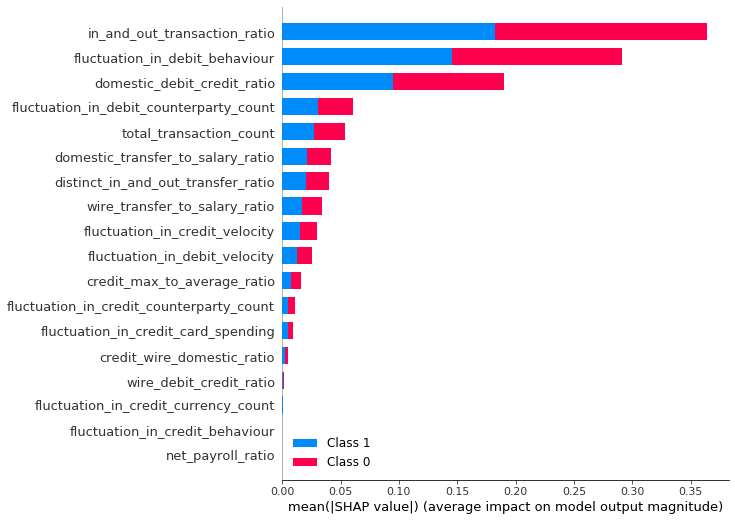

In [104]:
shap.summary_plot(shap_values,df_sample,plot_type='bar',show=False)

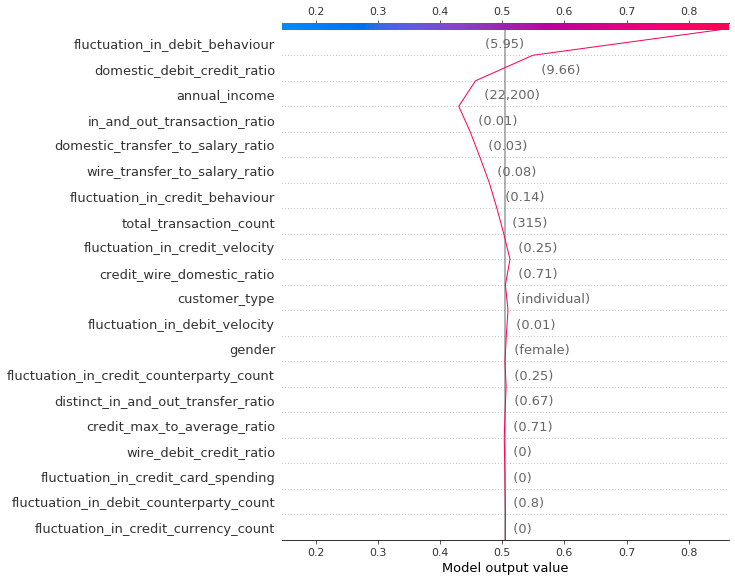

In [837]:
shap.decision_plot(expected_value, shap_values[1], test)

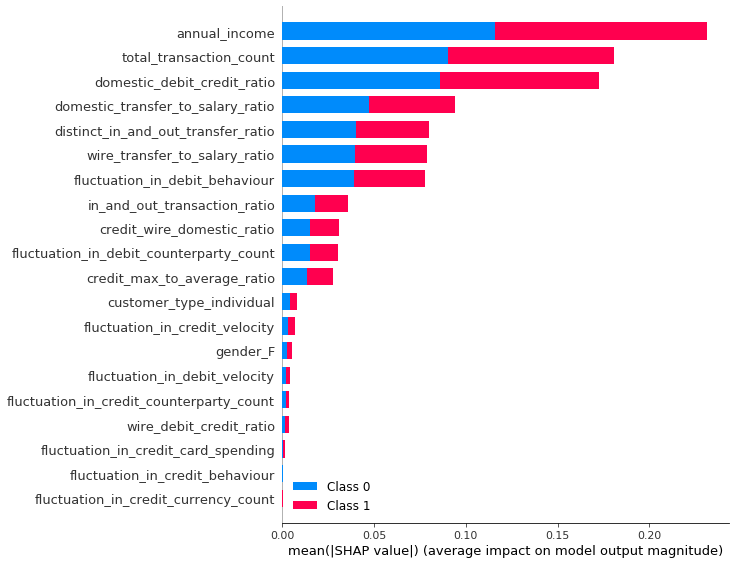

In [863]:
shap.summary_plot(shap_values,df_sample,plot_type='bar')

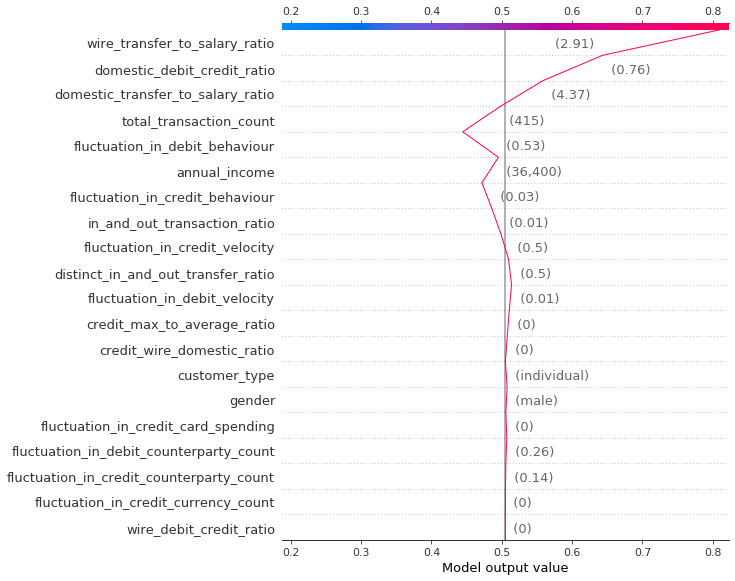

In [846]:
shap.decision_plot(expected_value, shap_values[1], test)